In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# !git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 12908, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 12908 (delta 49), reused 71 (delta 42), pack-reused 12825
Receiving objects: 100% (12908/12908), 12.36 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (8877/8877), done.
/content/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 4.2 MB/s 
Setup complete. Using torch 1.12.0+cu113 CPU


In [3]:
!pip install keras-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 570 kB/s 
     |████████████████████████████████| 944 kB 7.3 MB/s 
     |████████████████████████████████| 9.5 MB 38.5 MB/s 
     |████████████████████████████████| 604 kB 58.4 MB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=3383d07a19bd5edb3bf836cdd9052f20b4b4eb4cdee1669af2024faf7f28434e
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [4]:
import keras_ocr 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [5]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 1.1 MB 7.9 MB/s 
     |████████████████████████████████| 178 kB 25.8 MB/s 
     |████████████████████████████████| 4.3 MB 39.3 MB/s 
     |████████████████████████████████| 138 kB 46.7 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 21.6 MB 1.3 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
     |████████████████████████████████| 145 kB 42.8 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
roboflow 0.2.11 re

In [6]:
#after following the link above, recieve python code with these fields filled in
from roboflow import Roboflow
rf = Roboflow(api_key="MtQU52qWpcaThw2g5urt")
project = rf.workspace("test-pb7qy").project("monitor-vc9dl")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to monitor-1 in yolov5pytorch:: 100%|██████████| 136/136 [00:00<00:00, 1571.26it/s]


In [7]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat $dataset.location/data.yaml

names:
- monitor
nc: 1
train: monitor-1/train/images
val: monitor-1/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [8]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [10]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 4 --epochs 100 --data $dataset.location/data.yaml --cfg ./models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/monitor-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Traceback (most recent call last):
  File "train.py", line 666, in <module>
    main(opt)
  File "train.py", line 536, in main
    check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.weights), str(opt.project)  # checks
  File "/content/yolov5/utils/general.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

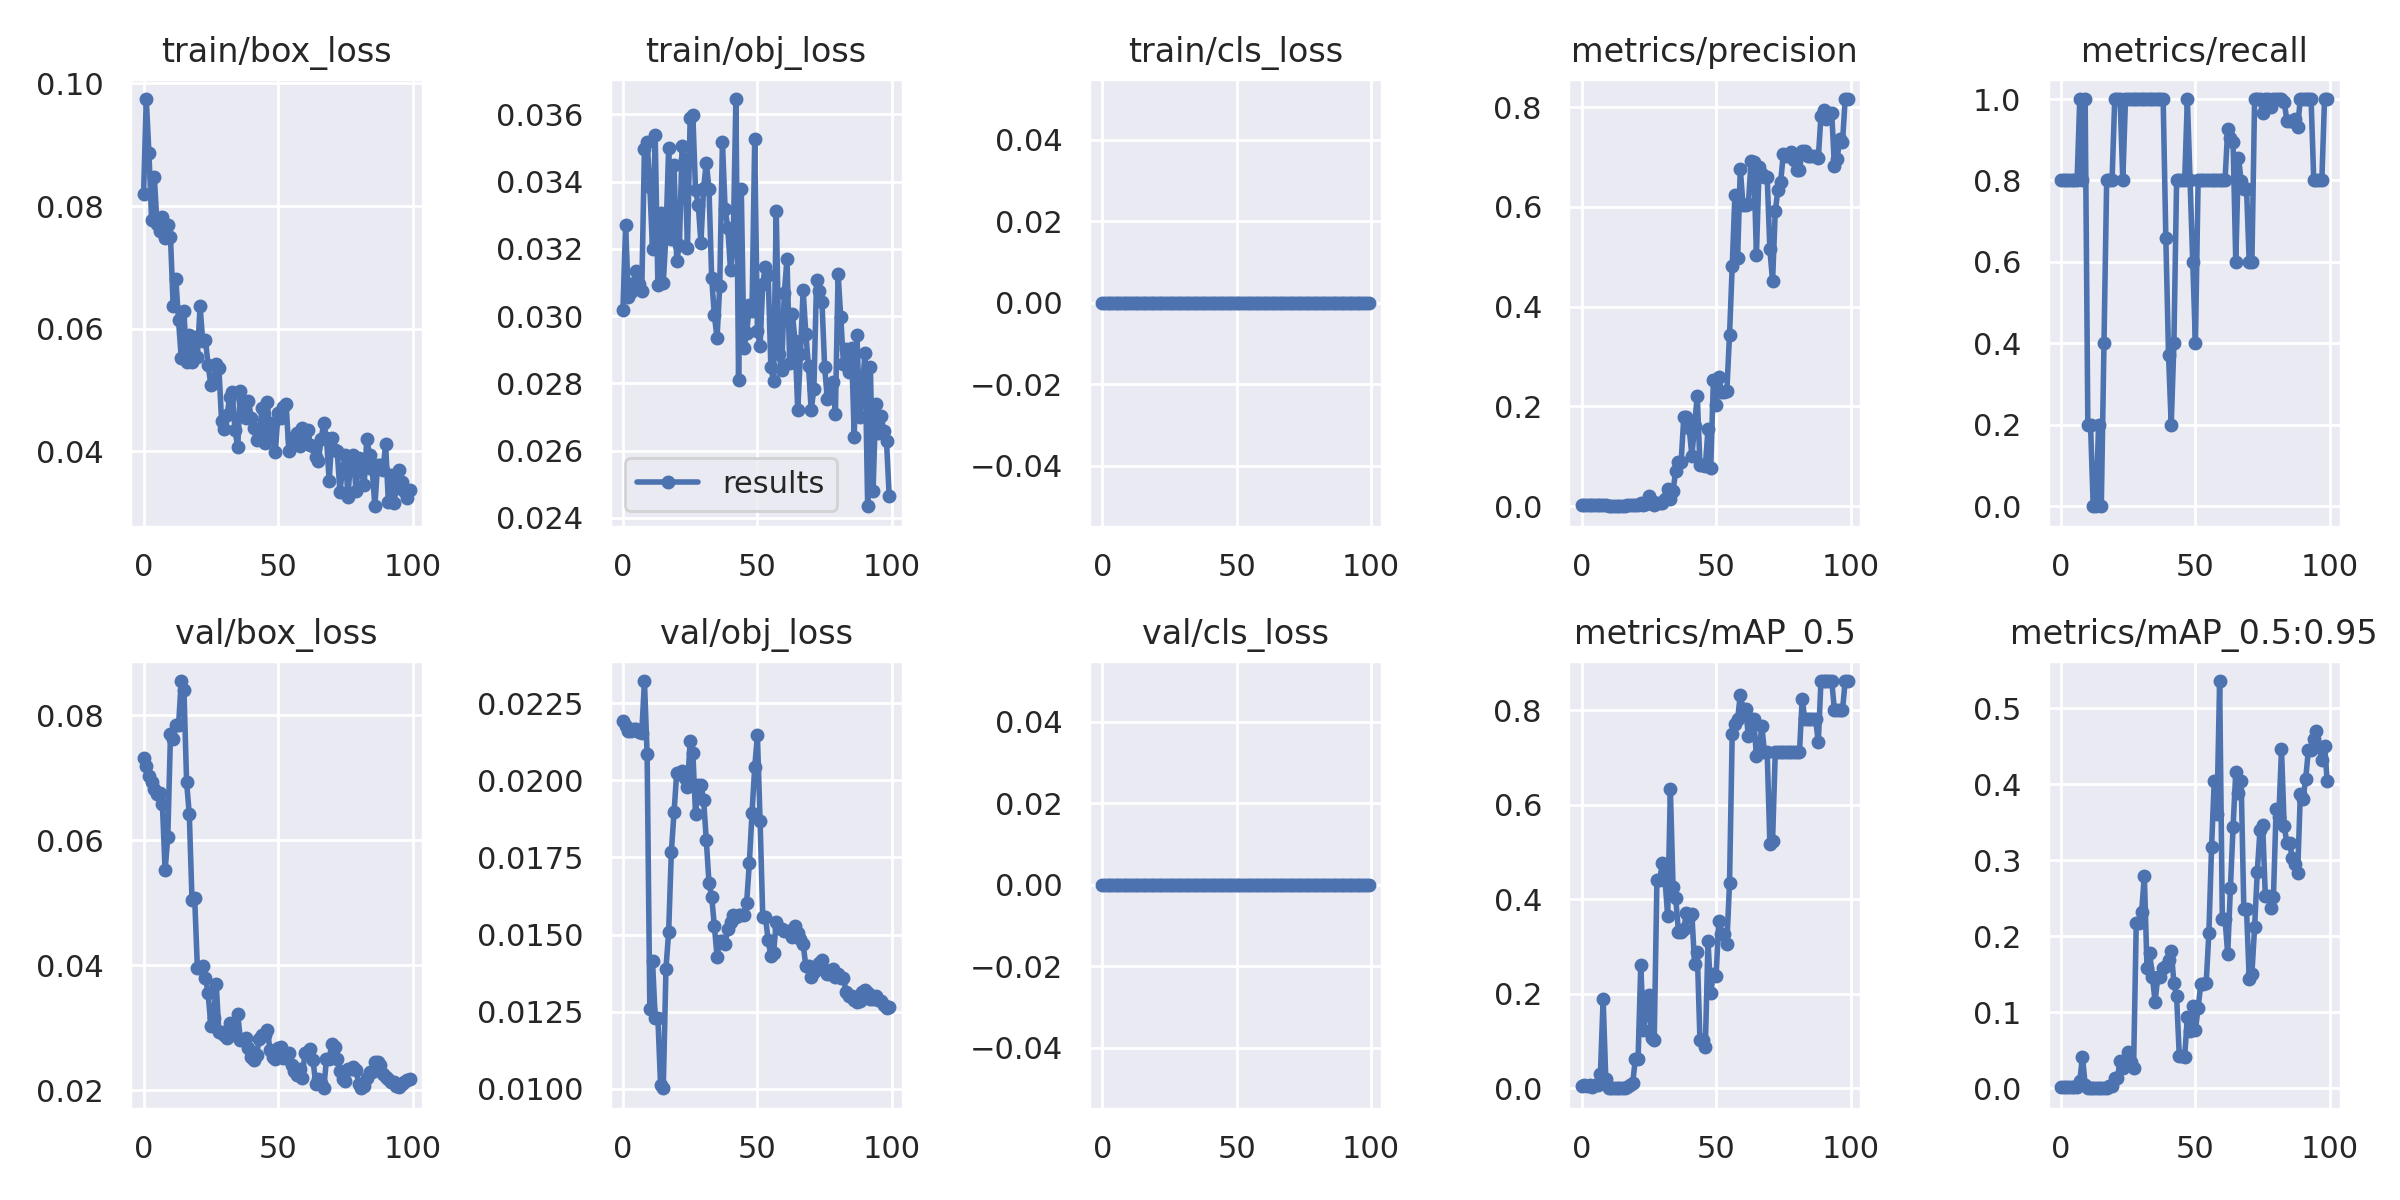

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH TRAINING DATA:


FileNotFoundError: ignored

GROUND TRUTH AUGMENTED TRAINING DATA:


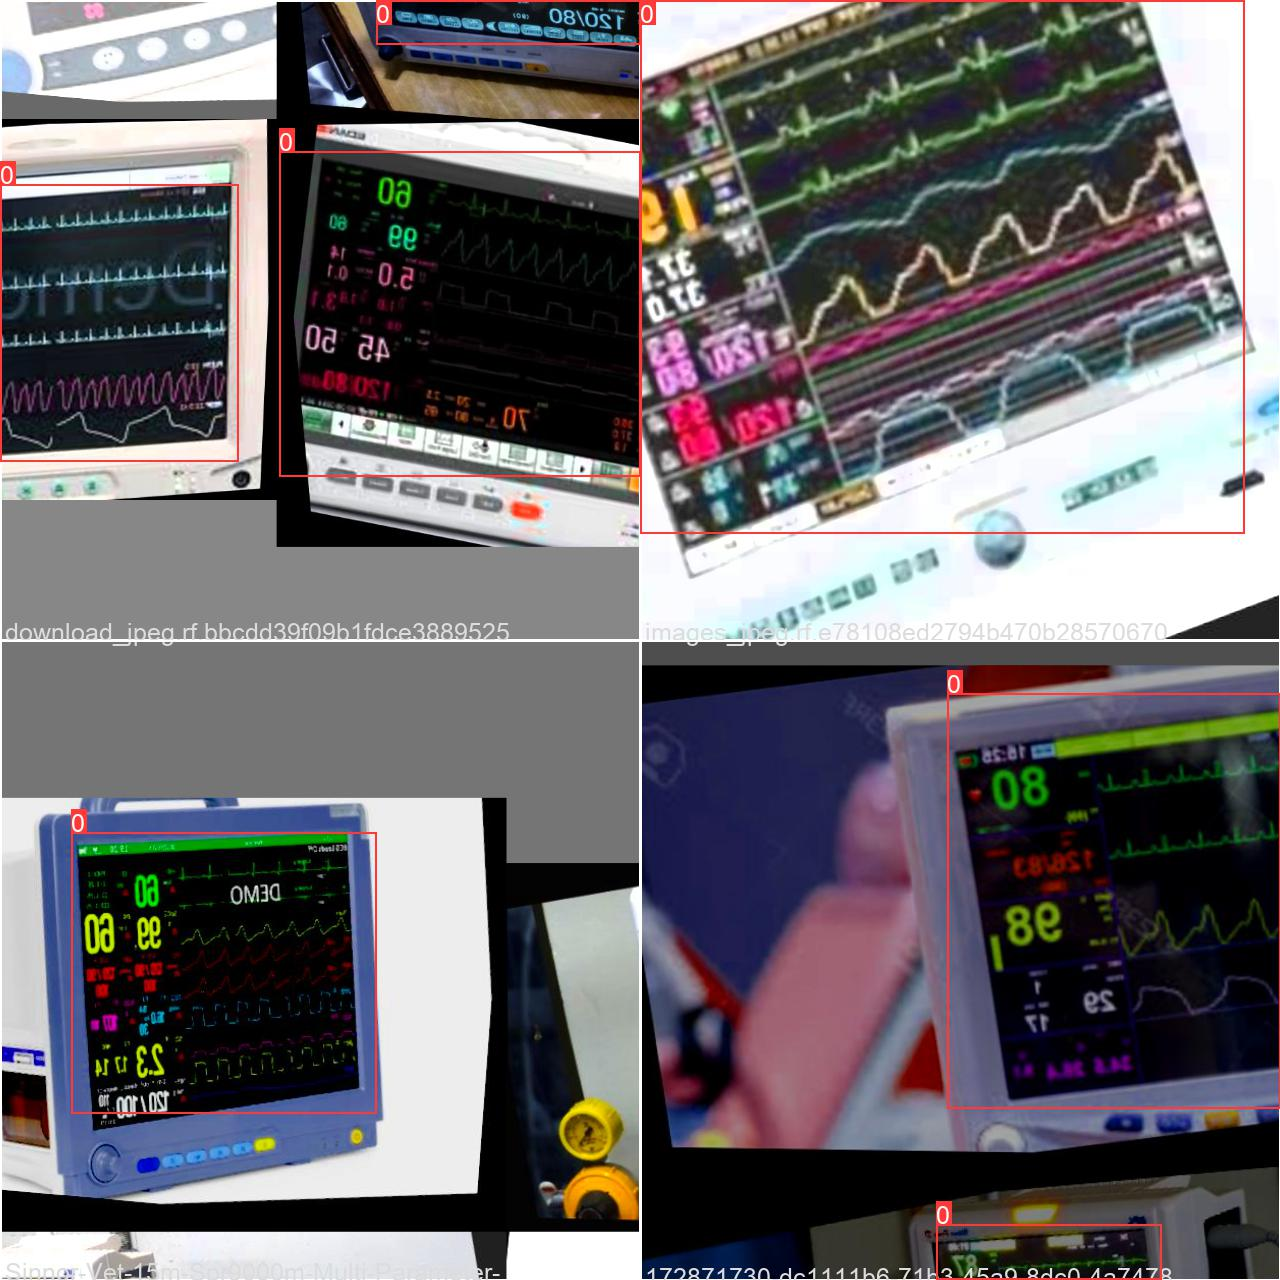

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
# %cd /content/yolov5/
!python detect.py --save-crop --weights /content/drive/"My Drive"/Care/last.pt --img 480 --conf 0.6 --source /content/drive/"My Drive"/Care/Dataset/image-2.png

detect: weights=['/content/drive/My Drive/Care/last.pt'], source=/content/drive/My Drive/Care/Dataset/image-2.png, data=data/coco128.yaml, imgsz=[480, 480], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-309-g4c1784b Python-3.7.13 torch-1.12.0+cu113 CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
image 1/1 /content/drive/My Drive/Care/Dataset/image-2.png: 288x480 1 monitor, Done. (0.213s)
Speed: 1.0ms pre-process, 213.5ms inference, 1.9ms NMS per image at shape (1, 3, 480, 480)
Results saved to runs/detect/exp2


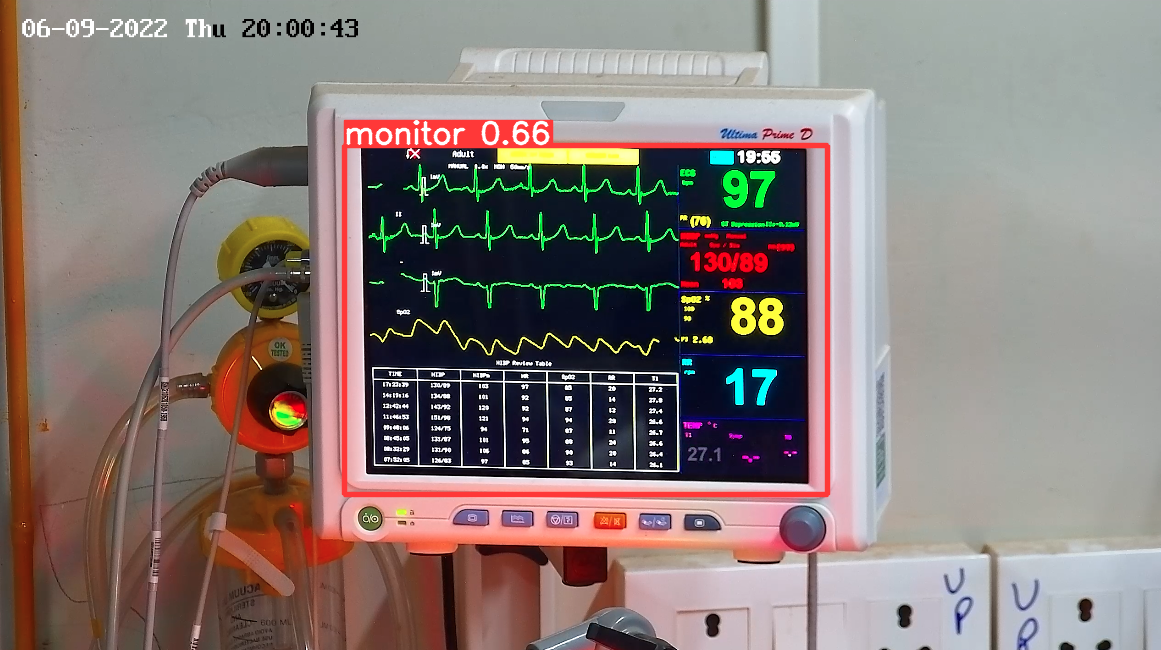

In [35]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.*'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [15]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import cv2
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt

In [36]:
dir_path = "/content/yolov5/runs/detect/exp2/crops/monitor"


img_path = dir_path + "/" + os.listdir(dir_path)[0]


In [37]:

img = cv2.imread(img_path)

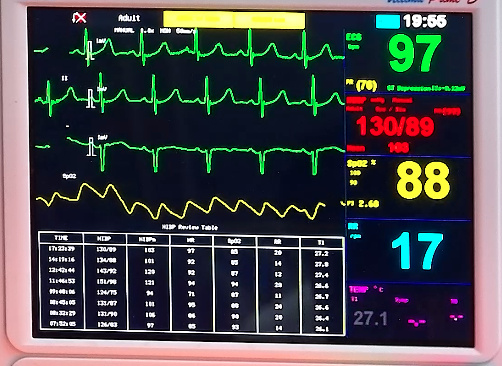

In [38]:
# plt.imshow(img)
cv2_imshow(img)

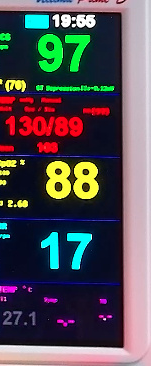

In [39]:
# getting image column
col = (img.shape[1]*70)//100

crop_img = img[:, col:]
cv2_imshow(crop_img)

In [40]:
# cv2.imwrite("/content/crop/img-crop.png", crop_img)
cv2.imwrite("/content/drive/My Drive/Care/Dataset/crop.png", crop_img)

True

In [41]:
cropped_image_path = "/content/drive/My Drive/Care/Dataset/crop.png"

In [42]:
images = [ keras_ocr.tools.read(path) for path in [
      cropped_image_path
]]

prediction_groups = pipeline.recognize(images)

print("-"*20)
headings = ["Blood Pressure", "Pulse Rate", "SpO2", "Respiratory Rate", "Temperature"]
counter = 0
for text, box in prediction_groups[0]:
  length = len(text)
  if(text.isnumeric() or "/" in text or "." in text):
    if((length == 2 or length == 3) and counter == 0):
      print(f"{headings[0]}: {text}")
      counter+=1
    elif("/" in text or length == 6 or length == 7 and counter == 1):
      text_1 = text[0:3]
      text_2 = text[4:]
      print(f"{headings[1]}: {text_1}/{text_2}")
      counter+=1
    elif(text.isnumeric() and int(text) >= 0 and int(text) <=100 and counter == 2):
      print(f"{headings[2]}: {text}")
      counter+=1
    elif(text.isnumeric() and length == 2 and counter == 3):
      print(f"{headings[3]}: {text}")
      counter+=1
    elif("." in text or length == 3 and (counter == 3 or counter == 4)):
      text_1 = text[0:2]
      text_2 = text[2:]
      print(f"{headings[4]}: {text_1}.{text_2}")

print("-"*20)


--------------------
Blood Pressure: 97
Pulse Rate: 130/89
SpO2: 88
Respiratory Rate: 17
Temperature: 21.1
--------------------


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive